# KNN Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import random

<Figure size 432x288 with 0 Axes>

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7f6a88b35430>

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [9]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform=features_fn,
    target_transform=target_fn,
    device=cpu,
    filter_fn = lambda df: df[(df['user_movie_rating_year'] >= 2014) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102038 entries, 0 to 102037
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      102038 non-null  int64         
 1   user_seq                     102038 non-null  int64         
 2   user_movie_tags              102038 non-null  object        
 3   user_movie_rating            102038 non-null  int64         
 4   user_movie_rating_timestamp  102038 non-null  datetime64[ns]
 5   user_movie_rating_year       102038 non-null  int64         
 6   movie_id                     102038 non-null  int64         
 7   movie_seq                    102038 non-null  int64         
 8   movie_title                  102038 non-null  string        
 9   movie_genres                 102038 non-null  object        
 10  movie_for_adults             102038 non-null  bool          
 11  movie_original_language   

In [11]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-05-18 16:28:15,844 - INFO - Train: 69.48 % - Test: 13.53 %


In [13]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

Building Ratting Matrix:   0%|          | 0/70898 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/8209 [00:00<?, ?it/s]

In [14]:
# user_predictor.plot()

In [15]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

Building Ratting Matrix:   0%|          | 0/70898 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/15194 [00:00<?, ?it/s]

In [16]:
# item_predictor.plot()

In [29]:
ratings = np.unique(dataset.target_uniques)

validator = ml.Validator(
    n_samples  = 100,
    batch_size = 500,
    metrics    = [
        #mt.RMSE(),
        # mt.FBetaScore(beta=1,discretizer=dr.round_sequence(ratings), num_classes=len(ratings)),
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5))
    ],
    predictors = [user_predictor, item_predictor]
)

summary = validator.validate(
    eval_set,
    n_neighbors=500
)

summary.save('../metrics/baseline')

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
summary = ml.ValidatorSummary.load('../metrics/baseline')

<Figure size 1440x360 with 2 Axes>

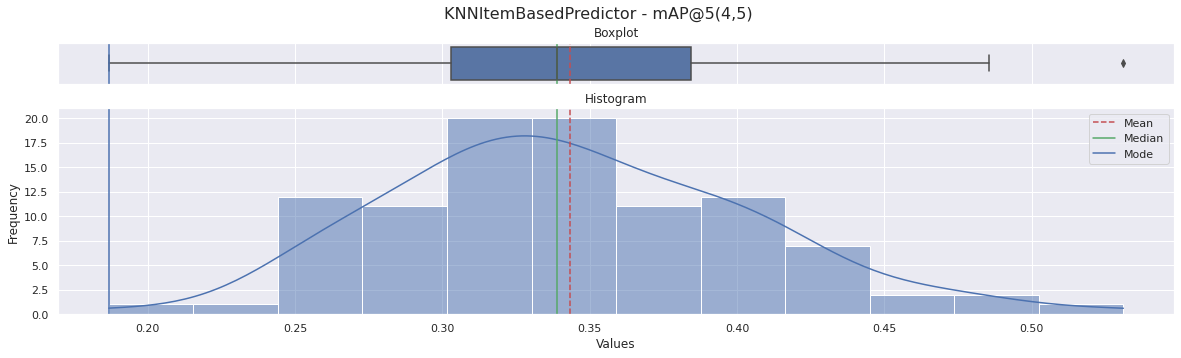


Metrics:



,"mAP@5(4,5)"
count,100.000000
mean,0.343290
std,0.061091
min,0.186769
25%,0.303003
50%,0.338948
75%,0.384266
max,0.531162


<Figure size 1440x360 with 2 Axes>

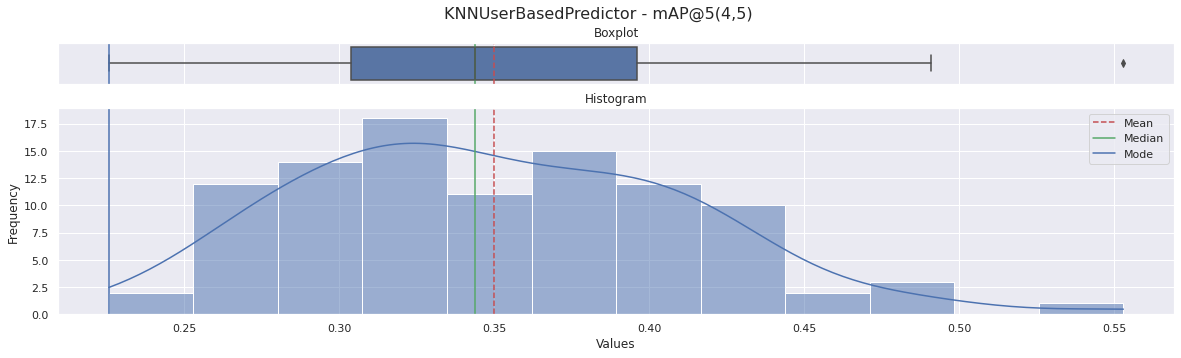


Metrics:



,"mAP@5(4,5)"
count,100.000000
mean,0.349856
std,0.062169
min,0.225704
25%,0.303706
50%,0.343761
75%,0.396193
max,0.552908


<Figure size 1440x360 with 2 Axes>

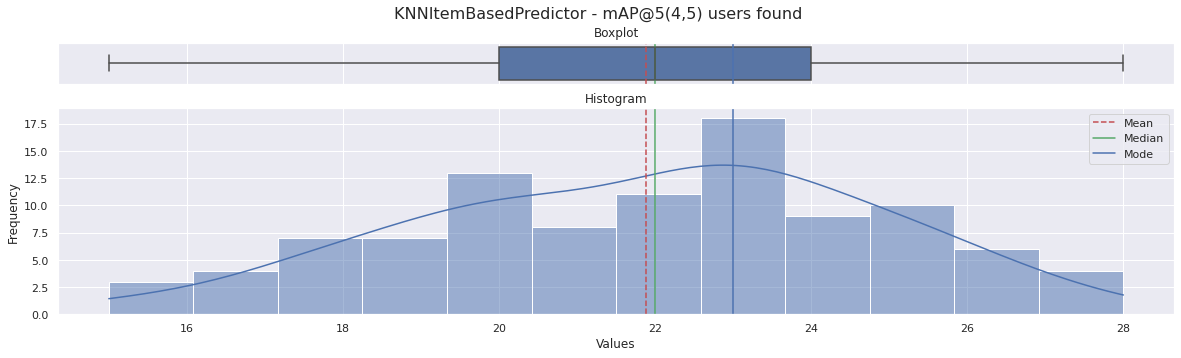


Metrics:



,"mAP@5(4,5) users found"
count,100.000000
mean,21.880000
std,2.875462
min,15.000000
25%,20.000000
50%,22.000000
75%,24.000000
max,28.000000


<Figure size 1440x360 with 2 Axes>

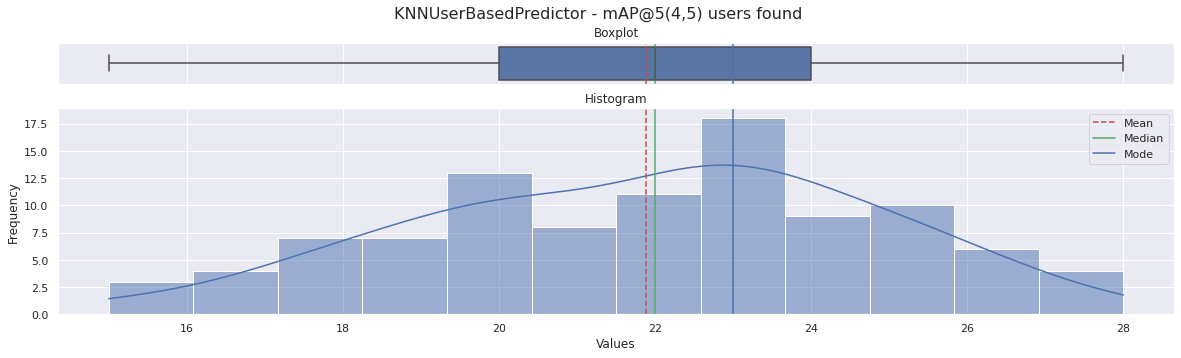


Metrics:



,"mAP@5(4,5) users found"
count,100.000000
mean,21.880000
std,2.875462
min,15.000000
25%,20.000000
50%,22.000000
75%,24.000000
max,28.000000


In [34]:
summary.plot(bins=12, show_table=True)